In [1]:
#!/usr/bin/env python
import os
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import rosbag

from utils import rosbag_utils
from utils.navigation_utils import get_local_xy_from_latlon
from utils.plot_utils import plot_single_data

### Load field data

In [2]:
# curr_dir = os.path.dirname(__file__)
curr_dir = "./"
ground_truth_path = os.path.join(curr_dir, "ground_truth/plant_field.pkl")

with open(ground_truth_path, 'rb') as file:
    field_data = pickle.load(file)

field_bound = {
    'latlon': field_data['field_bound_latlon'],
    'local': field_data['field_bound_local'],
}

utm_T_local = field_data['utm_T_local']

### Load bag file

In [3]:
bag_path = '/media/lab/NEPTUNE2/field_raw_datasets/2022-12-06_Human/px4_2022-11-30-15-10-00.bag'

bag = rosbag.Bag(bag_path, "r")
rosbag_utils.print_bag_topics(bag)

Available topics: 
------------------------------
'/mavros/global_position/raw/satellites'   (msg_type=std_msgs/UInt32, frequency=5.00Hz)
'/d435i/aligned_depth_to_color/image_raw/compressed'   (msg_type=sensor_msgs/CompressedImage, frequency=14.58Hz)
'/mavros/local_position/velocity_body'   (msg_type=geometry_msgs/TwistStamped, frequency=29.99Hz)
'/mavros/imu/data_raw'   (msg_type=sensor_msgs/Imu, frequency=50.03Hz)
'/d435i/aligned_depth_to_color/camera_info'   (msg_type=sensor_msgs/CameraInfo, frequency=14.58Hz)
'/tf'   (msg_type=tf2_msgs/TFMessage, frequency=283.11Hz)
'/mavros/setpoint_raw/target_local'   (msg_type=mavros_msgs/PositionTarget, frequency=10.00Hz)
'/mavros/gpsstatus/gps1/raw'   (msg_type=mavros_msgs/GPSRAW, frequency=5.00Hz)
'/mavros/altitude'   (msg_type=mavros_msgs/Altitude, frequency=10.00Hz)
'/mavros/global_position/compass_hdg'   (msg_type=std_msgs/Float64, frequency=50.08Hz)
'/mavros/distance_sensor/rangefinder_pub'   (msg_type=sensor_msgs/Range, frequency=10.00Hz

In [4]:
global_position = rosbag_utils.get_topic_from_bag(bag, "/mavros/global_position/global", False)
compass_hdg = rosbag_utils.get_topic_from_bag(bag, "/mavros/global_position/compass_hdg", False)
local_position = rosbag_utils.get_topic_from_bag(bag, "/mavros/local_position/odom", False)
velocity_body = rosbag_utils.get_topic_from_bag(bag, "/mavros/local_position/velocity_body", False)
rc_in = rosbag_utils.get_topic_from_bag(bag, "/mavros/rc/in", False)
setpoint_raw = rosbag_utils.get_topic_from_bag(bag, "/mavros/setpoint_raw/local", False)

offboard_start_time = setpoint_raw['ros_time'].iloc[0]
offboard_stop_time = setpoint_raw['ros_time'].iloc[-1]

global_position_crop = rosbag_utils.crop_data_with_start_end_time(global_position, offboard_start_time, offboard_stop_time)
compass_hdg_crop = rosbag_utils.crop_data_with_start_end_time(compass_hdg, offboard_start_time, offboard_stop_time)
local_position_crop = rosbag_utils.crop_data_with_start_end_time(local_position, offboard_start_time, offboard_stop_time)
velocity_body_crop = rosbag_utils.crop_data_with_start_end_time(velocity_body, offboard_start_time, offboard_stop_time)
rc_in_crop = rosbag_utils.crop_data_with_start_end_time(rc_in, offboard_start_time, offboard_stop_time)

ros_time, sync_topics = rosbag_utils.timesync_topics([
    setpoint_raw,
    global_position_crop,
    compass_hdg_crop,
    local_position_crop,
    velocity_body_crop,
], printout=True)

setpoint_raw_sync = sync_topics[0]
global_position_sync = sync_topics[1]
compass_hdg_sync = sync_topics[2]
local_position_sync = sync_topics[3]
velocity_body_sync = sync_topics[4]


Use the 0 column as the base. The synchronized frequency is 30Hz.


Text(0.5,0,'time [s]')

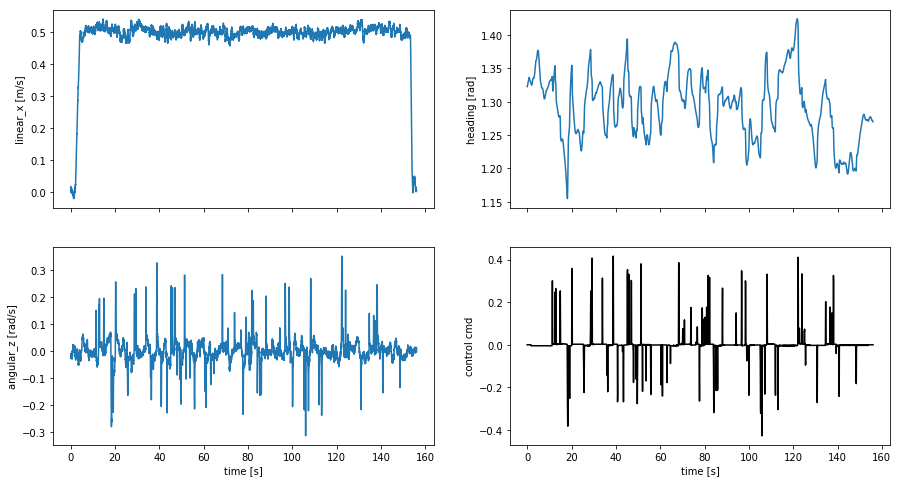

In [5]:
# heading
compass_heading = np.radians(compass_hdg_sync['data'])

# local position utm
utm_local_pos_x = []
utm_local_pos_y = []
for i in range(len(global_position_sync)):
    pos_xy = get_local_xy_from_latlon(
        global_position_sync['latitude'].iloc[i],
        global_position_sync['longitude'].iloc[i],
        utm_T_local,
    )
    utm_local_pos_x.append(pos_xy[0])
    utm_local_pos_y.append(pos_xy[1])

utm_local_pos_x = np.array(utm_local_pos_x)
utm_local_pos_y = np.array(utm_local_pos_y)

# local odom position
odom_local_pos_z = []
for pose_msg in local_position_sync['pose']:
    odom_local_pos_z.append(pose_msg.pose.position.z)
odom_local_pos_z = np.array(odom_local_pos_z)

# yaw rate cmd
yaw_rate_cmd = setpoint_raw_sync['yaw_rate'].to_numpy()
yaw_rate_cmd = -yaw_rate_cmd / (45.0 * np.pi / 180)
yaw_rate_cmd[abs(yaw_rate_cmd) < 1e-2] = 0.0

# velocity body
linear_x = []
for twist_msg in velocity_body_sync['twist']:
    linear_x.append(twist_msg.linear.x)
linear_x = np.array(linear_x)

angular_z = []
for twist_msg in velocity_body_sync['twist']:
    angular_z.append(twist_msg.angular.z)
angular_z = np.array(angular_z)

# plot
ros_time = ros_time - ros_time[0]
fig, axes = plt.subplots(2,2,sharex=True,figsize=(15,8))
# linear_x
axes[0][0].plot(ros_time, linear_x)
axes[0][0].set_ylabel('linear_x [m/s]')
# angular_z
axes[1][0].plot(ros_time, angular_z)
axes[1][0].set_ylabel('angular_z [rad/s]')
axes[1][0].set_xlabel('time [s]')
# heading
axes[0][1].plot(ros_time, compass_heading)
axes[0][1].set_ylabel('heading [rad]')
# yaw_rate cmd
axes[1][1].plot(ros_time, yaw_rate_cmd, color='k')
axes[1][1].set_ylabel('control cmd')
axes[1][1].set_xlabel('time [s]')

# angular_z
# axes[1][1].plot(ros_time, angular_z)
# axes[1][1].set_ylabel('angular_z [rad/s]')

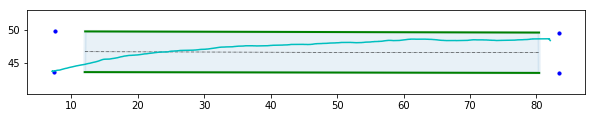

In [6]:
fig, axis = plt.subplots(1,1, figsize=(10,10))
plot_single_data(axis, field_data['row_data'][5])
axis.plot(utm_local_pos_x, utm_local_pos_y, color='c')